LINK TO DATASET : `https://www.kaggle.com/datasets/jainilcoder/netflix-stock-price-prediction`

# Bài thi giữa kì môn Khoa học dữ liệu

## Bộ dữ liệu sử dụng : Netflix Stock Price Prediction

### Vấn đề:
    Giải quyết bài toán dự đoán giá trị cổ phiếu của Netflix :
- Khai phá dữ liệu bao gồm hình thành đặc trưng (feature) mới như EMA hay các giá trị để tăng độ chính xác cho dự báo
- Áp dụng các kĩ thuật chuẩn hóa dữ liệu (nếu cần có)
- Lựa chọn model Random Forest cho việc lựa chọn và đánh giá mô hình
- Phân chia tập dữ liệu train và test để đánh giá độ hiểu quả (Trong đó bao gồm có xử lí cross_validation)

`Import thư viện`

In [423]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta
import warnings
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import accuracy_score
from scipy.stats import loguniform
from sklearn.model_selection import cross_validate
warnings.filterwarnings('ignore')

`Đọc file csv`

In [424]:
data = pd.read_csv('NFLX.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200


`Thông tin của data`

In [425]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


`Vẽ giá cổ phiếu Netflix cho toàn bộ thời gian (5.2.2018 - 4.2.2022)`

Text(0.5, 1.0, 'Giá cổ phiếu Netflix cho toàn bộ thời gian (2018 - 2022)')

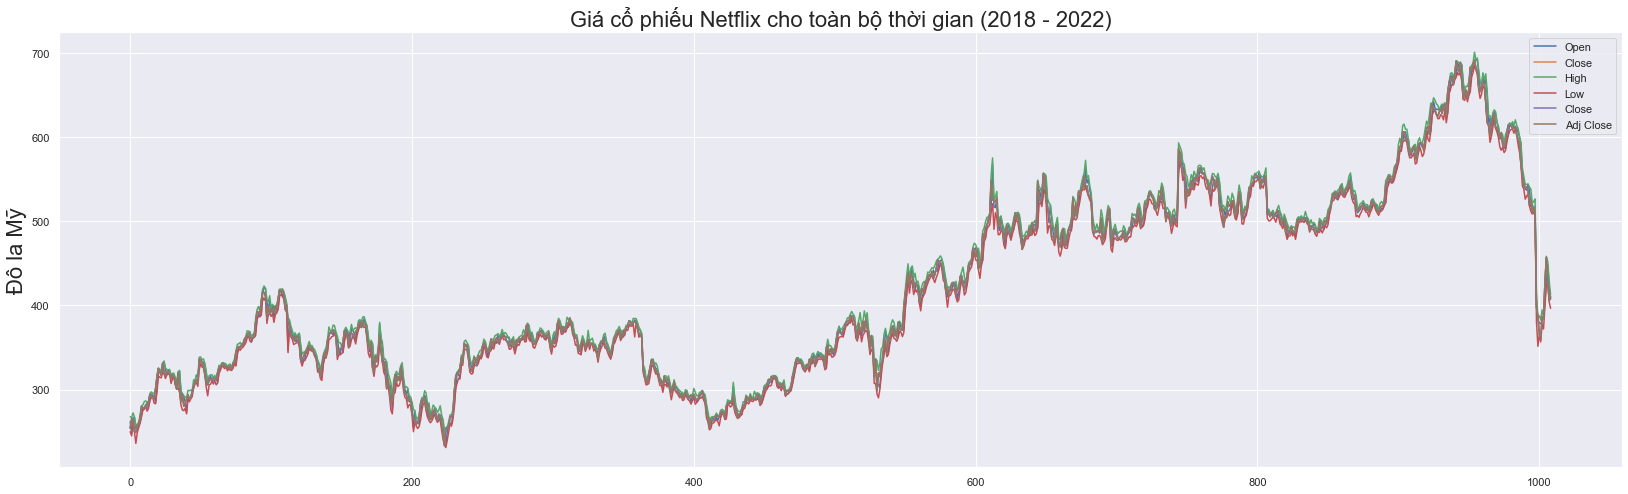

In [426]:
data[['Open', 'Close', 'High','Low','Close','Adj Close']].plot(figsize=(28,8))
plt.ylabel('Đô la Mỹ', fontsize = 22)
plt.title("Giá cổ phiếu Netflix cho toàn bộ thời gian (2018 - 2022)", fontsize=22)

# `Xây dựng mô hình`

In [427]:
conditions = [(data['Open'] - data['Close']) < 0, (data['Open'] - data['Close']) > 0]
values = [1, 0]
data['PosSession'] = np.select(conditions, values, default = 1)
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,PosSession
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100,0
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800,1
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500,0
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700,0
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900,0


In [428]:
newfeatures = pd.DataFrame(data["Adj Close"])
newfeatures = newfeatures.rename(columns = {"Adj Close": 'Actual_Close'})
newfeatures['Target'] = data.rolling(window=2).apply(lambda x: x.iloc[1] > x.iloc[0])["Adj Close"]
newfeatures.head()

,Actual_Close,Target
0,254.259995,NaN
1,265.720001,1.0
2,264.559998,0.0
3,250.100006,0.0
4,249.470001,0.0


In [433]:
data['Target'] = newfeatures['Target']
data = data.iloc[1:]
data

,Date,Open,High,Low,Close,Adj Close,Volume,PosSession,Target
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800,1,1.0
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500,0,0.0
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700,0,0.0
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900,0,0.0
5,2018-02-12,252.139999,259.149994,249.000000,257.950012,257.950012,8534900,1,1.0
...,...,...,...,...,...,...,...,...,...
1004,2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500,1,1.0
1005,2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300,1,1.0
1006,2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000,0,0.0
1007,2022-02-03,421.440002,429.260010,404.279999,405.600006,405.600006,9905200,0,0.0


In [434]:
data['Target'].value_counts()

1.0    516
0.0    492
Name: Target, dtype: int64

`Thực hiện với tham số mặc định`

In [435]:
predictors = ['Open', 'High', 'Low', 'Close', 'Volume', 'PosSession']

In [436]:
def logisticRegression(data):
    accuracy_score_arr = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=i)
        model = LogisticRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy_score_arr.append(accuracy_score(y_test, y_pred))
    accuracy_score_arr = np.array(accuracy_score_arr)
    return accuracy_score_arr.mean()

print("Độ chính xác của thuật toán Logistic Regression: ", logisticRegression(data))


Độ chính xác của thuật toán Logistic Regression:  0.48316831683168315


`Lựa chọn tham số`

In [376]:
def selection_hyperparameters_model(data):
    params = []
    scores = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=i)
        model = LogisticRegression()
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        space = dict()
        space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
        space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
        space['C'] = loguniform(1e-5, 100)
        search = RandomizedSearchCV(model, space, cv=cv, scoring='accuracy', n_iter=100, n_jobs=-1, random_state=1)
        result = search.fit(X_train, y_train)
        params.append(result.best_params_)
        scores.append(result.best_score_)
    return params, scores
        
best_params_,best_score= selection_hyperparameters_model(data=data)

In [377]:
dataframe = {'params': best_params_, 'scores': best_score}
paramsdf = pd.DataFrame(dataframe)
paramsdf

,params,scores
0,"{'C': 0.00026987692189069833, 'penalty': 'l2',...",0.548786
1,"{'C': 0.00026987692189069833, 'penalty': 'l2',...",0.554496
2,"{'C': 0.004556412214150533, 'penalty': 'l2', '...",0.545129
3,"{'C': 61.259047279891696, 'penalty': 'l2', 'so...",0.547917
4,"{'C': 0.00026987692189069833, 'penalty': 'l2',...",0.562876
5,"{'C': 0.00026987692189069833, 'penalty': 'l2',...",0.542145
6,"{'C': 0.00011762747049187036, 'penalty': 'l2',...",0.543940
7,"{'C': 61.259047279891696, 'penalty': 'l2', 'so...",0.554218
8,"{'C': 9.544712125688203e-05, 'penalty': 'l2', ...",0.538930
9,"{'C': 61.259047279891696, 'penalty': 'l2', 'so...",0.543035


In [379]:
def rating_model(data, best_params_):
    fit_time = []
    test_score = []
    train_score = []
    score_time = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=i)
        model = LogisticRegression(C = best_params_[i]['C'], penalty = best_params_[i]['penalty'], solver = best_params_[i]['solver'])
        result = cross_validate(model, X_train, y_train, cv=10, scoring='accuracy', return_train_score=True)
        fit_time.append(result['fit_time'].mean())
        test_score.append(result['test_score'].mean())
        train_score.append(result['train_score'].mean())
        score_time.append(result['score_time'].mean())
    return fit_time, test_score, train_score, score_time

fit_time, test_score, train_score, score_time = rating_model(data, best_params_)

dataframe = {'fit_time': fit_time, 'test_score': test_score, 'train_score': train_score, 'score_time': score_time}
df = pd.DataFrame(dataframe)
df["iteration"] = np.arange(10)
df

,fit_time,test_score,train_score,score_time,iteration
0,0.134042,0.547253,0.556523,0.001794,0
1,0.172040,0.539799,0.561622,0.001799,1
2,0.135635,0.534877,0.555836,0.001397,2
3,0.098935,0.547176,0.559004,0.001098,3
4,0.129957,0.568179,0.571408,0.001592,4
5,0.118283,0.550741,0.546736,0.001000,5
6,0.136436,0.538364,0.545768,0.001095,6
7,0.114993,0.562238,0.562176,0.001099,7
8,0.118085,0.529769,0.536532,0.000997,8
9,0.148604,0.549583,0.565483,0.001495,9


In [380]:
fit_time_asc = df['fit_time'].sort_values(ascending=True)
score_time_asc = df['score_time'].sort_values(ascending=True)
test_score_desc = df['test_score'].sort_values(ascending=False)
train_score_desc = df['train_score'].sort_values(ascending=False) 

In [381]:
dataframe = {'Xếp hạng': ['Thứ 1', 'Thứ 2', 'Thứ 3'],
            'fit_time' : [df.loc[df['fit_time'] == fit_time_asc.iloc[0], 'iteration'].item(), df.loc[df['fit_time'] == fit_time_asc.iloc[1], 'iteration'].item(), df.loc[df['fit_time'] == fit_time_asc.iloc[2], 'iteration'].item()],
            'score_time' : [df.loc[df['score_time'] == score_time_asc.iloc[0], 'iteration'].item(), df.loc[df['score_time'] == score_time_asc.iloc[1], 'iteration'].item(), df.loc[df['score_time'] == score_time_asc.iloc[2], 'iteration'].item()],
            'test_score' : [df.loc[df['test_score'] == test_score_desc.iloc[0], 'iteration'].item(), df.loc[df['test_score'] == test_score_desc.iloc[1], 'iteration'].item(), df.loc[df['test_score'] == test_score_desc.iloc[2], 'iteration'].item()],
            'train_score' : [df.loc[df['train_score'] == train_score_desc.iloc[0], 'iteration'].item(), df.loc[df['train_score'] == train_score_desc.iloc[1], 'iteration'].item(), df.loc[df['train_score'] == train_score_desc.iloc[2], 'iteration'].item()]}
df = pd.DataFrame(dataframe)
df


,Xếp hạng,fit_time,score_time,test_score,train_score
0,Thứ 1,3,8,4,4
1,Thứ 2,7,5,7,9
2,Thứ 3,8,6,5,7


In [404]:
best_param_logistic = best_params_[2]

In [408]:
def logisticRegressionWithHyperparameter(data, params):
    accuracy_score_arr = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(data[predictors], data['Target'], test_size=0.2, random_state=i)
        model = LogisticRegression(C = params['C'], solver = params['solver'], penalty = params['penalty'])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy_score_arr.append(accuracy_score(y_test, y_pred))
    accuracy_score_arr = np.array(accuracy_score_arr)
    return accuracy_score_arr.mean()

print("Độ chính xác của thuật toán Logistic Regression với cấu hình siêu tham số:  ", logisticRegressionWithHyperparameter(data, best_param_logistic))

Độ chính xác của thuật toán Logistic Regression với cấu hình siêu tham số:   0.5524752475247525


In [406]:
print("Độ sai lệch trong bộ tính toán giữa 2 cách: ", (logisticRegressionWithHyperparameter(data, best_param_logistic) - logisticRegression(data)) * 100,"%")

Độ sai lệch trong bộ tính toán giữa 2 cách:  6.039603960396045 %
